# Data collection

          x          y
0 -1.566699   1.496714
1 -1.218544   1.861736
2 -0.870388   3.647689
3 -0.522233   5.523030
4 -0.174078   4.765847
5  0.174078   5.765863
6  0.522233   8.579213
7  0.870388   8.767435
8  1.218544   8.530526
9  1.566699  10.542560


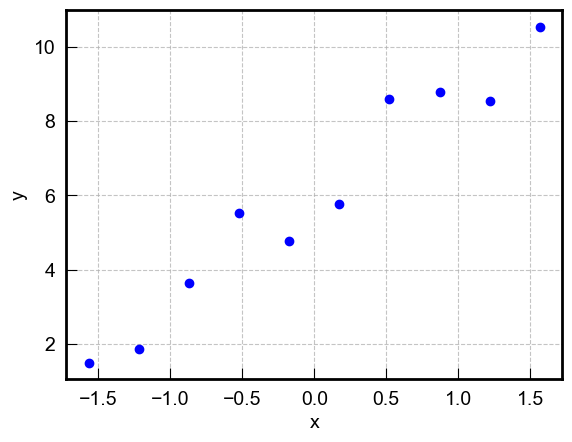

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

if os.path.exists("/home2/jianhuang/projects/packages/toolbox/plot/mystyle.mplstyle"):
    plt.style.use("/home2/jianhuang/projects/packages/toolbox/plot/mystyle.mplstyle")

# reproducibility
np.random.seed(42)

# x values
x = np.arange(1, 11)

# true relationship y = 3x + 5 with Gaussian noise
np.random.seed(42)
noise = np.random.normal(0, 1, size=len(x))
y = 1 * x + noise

# --- Normalize x ---
x_mean = np.mean(x)
x_std = np.std(x)
x_norm = (x - x_mean) / x_std
x = x_norm

# make dataframe
df = pd.DataFrame({"x": x, "y": y})
print(df)

# plot
plt.plot(x, y, "bo")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Model hypothesis

Assuming the hidden model for x-y relationshio follows **Linear relationship**, mathematically:

$$
y = w * x + b
$$

From the standard least-squares formulas, we can analytically calculate the **w** and **b** values as follows:

$$
w = \frac{\sum_{i=1}^n \left(x_i - \bar{x}\right)\left(y_i - \bar{y}\right)}
         {\sum_{i=1}^n \left(x_i - \bar{x}\right)^2}
$$

$$
b = \bar{y} - w \,\bar{x}
$$

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^n x_i,
\quad
\bar{y} = \frac{1}{n} \sum_{i=1}^n y_i
$$



# Analytical/Closed form 

In [4]:
# analytical solution
n = len(x)

# --- Centered form ---
x_mean = np.mean(x)
y_mean = np.mean(y)

w_centered = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean)**2)
b_centered = y_mean - w_centered * x_mean


print("Analytical solution: w = {:.4f}, b = {:.4f}".format(w_centered, b_centered))


Analytical solution: w = 2.8525, b = 5.9481


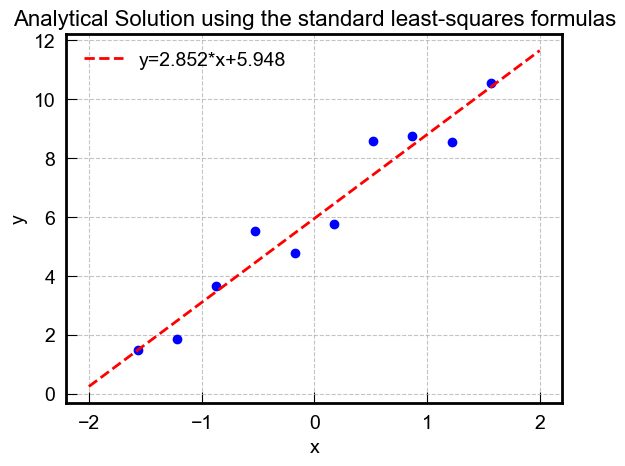

In [5]:
# 
x_ana = np.linspace(-2, 2, 50)
y_ana = x_ana * w_centered + b_centered

# plot
plt.plot(x, y, "bo")
plt.plot(x_ana, y_ana, "r--", label=f"y={w_centered:.3f}*x+{b_centered:.3f}")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytical Solution using the standard least-squares formulas")
plt.legend()
plt.show()

# Loss function

Loss function (Mean Squared Error)
$$
\mathcal{L}(w, b) = \frac{1}{n} \sum_{i=1}^n \big( y_i - (w x_i + b) \big)^2
$$

# 0-th order global search

Basically, enumerate all combinations of **w** and **b** values and find the least Loss

In [6]:
# --- Loss function ---
def mse_loss(w, b, x, y):
    return np.mean((y - (w*x + b))**2)

# --- Closed-form minimum ---
n = len(x_norm)
w_min = (n*np.sum(x_norm*y) - np.sum(x_norm)*np.sum(y)) / (n*np.sum(x_norm**2) - (np.sum(x_norm))**2)
b_min = (np.sum(y) - w_min*np.sum(x_norm)) / n
loss_min = mse_loss(w_min, b_min, x_norm, y)
print(f"w_min: {w_min}")
print(f"b_min: {b_min}")
print(f"loss_min: {loss_min}")

# --- Grid around minimum ---
w_vals = np.linspace(w_min - 2, w_min + 2, 100)
b_vals = np.linspace(b_min - 2, b_min + 2, 100)
W, B = np.meshgrid(w_vals, b_vals)
Loss = np.array([[mse_loss(w,b,x_norm,y) for w in w_vals] for b in b_vals])


w_min: 2.852461514557788
b_min: 5.948061111698756
loss_min: 0.47007412039580687


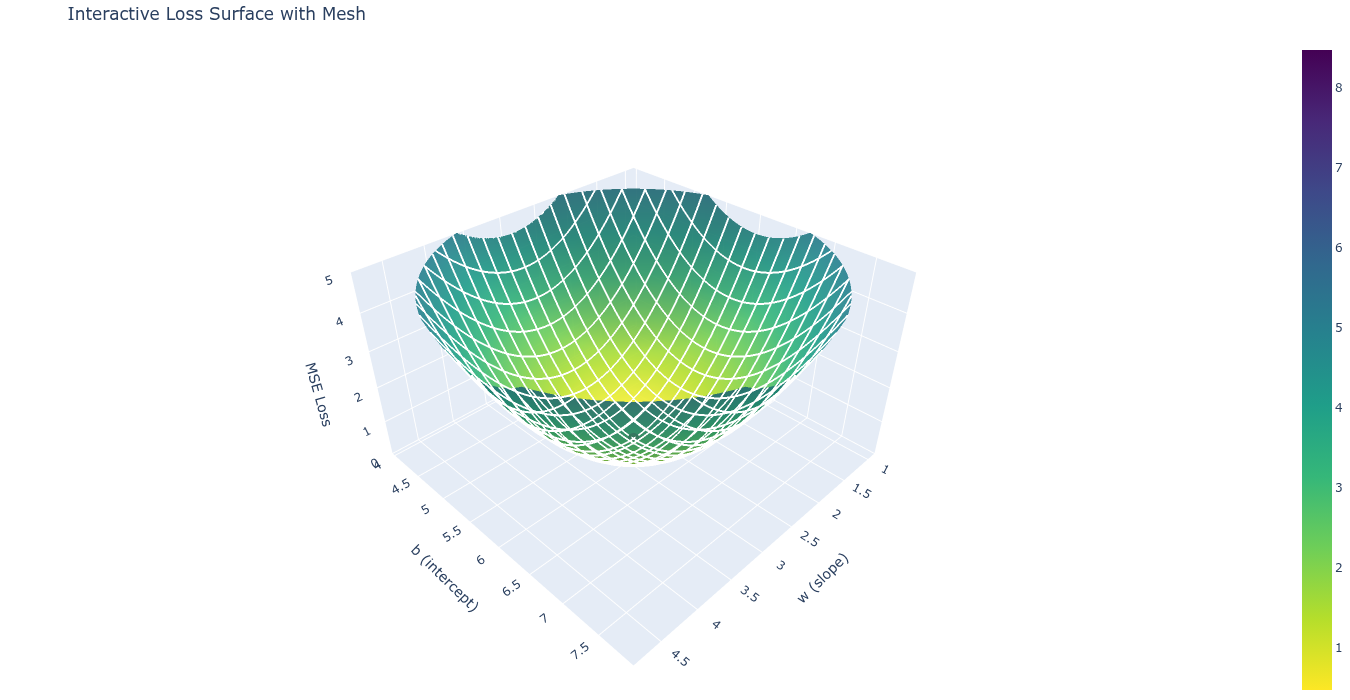

In [7]:
# --- Plotly 3D surface with mesh ---
fig = go.Figure(data=[go.Surface(
    x=W,
    y=B,
    z=Loss,
    colorscale='Viridis_r',
    opacity=0.9,
    showscale=True,
    contours = {
        "x": {"show": True, "start": w_vals[0], "end": w_vals[-1], "size": 0.2, "color":"white"},
        "y": {"show": True, "start": b_vals[0], "end": b_vals[-1], "size": 0.2, "color":"white"}
    }
)])

# Highlight the minimum
fig.add_trace(go.Scatter3d(
    x=[w_min],
    y=[b_min],
    z=[loss_min],
    mode='markers',
    marker=dict(color='red', size=7),
    name='Minimum', 
    showlegend=False
))


# Layout
fig.update_layout(
    scene=dict(
        xaxis_title='w (slope)',
        yaxis_title='b (intercept)',
        zaxis_title='MSE Loss'
    ),
    title='Interactive Loss Surface with Mesh',
    width=900,
    height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)


fig.update_layout(
    scene=dict(
        xaxis=dict(title='w (slope)', range=[w_min-2, w_min+2]),
        yaxis=dict(title='b (intercept)', range=[b_min-2, b_min+2]),
        zaxis=dict(title='MSE Loss', range=[0, 5])
    )
)

fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.6)  # reduce z-height relative to x and y
    )
)

fig.show()

# 0-th order local optimization: random search

Starting from a randomly choosen **w** and **b**, we randomly search the local using randomly generated directional vectors

We descent the Loss function to give the least Loss each step

In [8]:
# --- Random greedy search ---
def random_greedy_search(current_w=4, current_b=7, num_iterations=20, directions=10, step_size=0.1):
    global x, y
    # current_w, current_b = 4, 7
    # num_iterations = 20
    candidates = directions
    # step_size = 0.1
    
    random_search_path = [(current_w, current_b, mse_loss(current_w, current_b, x, y))]
    print(f"Step 0: w={current_w:.3f}, b={current_b:.3f}, loss={random_search_path[-1][2]:.3f}")
    
    for step in range(1, num_iterations+1):
        # generate candidate points
        w_candidates = current_w + np.random.uniform(-step_size, step_size, candidates)
        b_candidates = current_b + np.random.uniform(-step_size, step_size, candidates)
        
        losses = [mse_loss(wc, bc, x, y) for wc, bc in zip(w_candidates, b_candidates)]
        
        # choose the candidate with the lowest loss
        min_idx = np.argmin(losses)
        current_w, current_b = w_candidates[min_idx], b_candidates[min_idx]
        current_loss = losses[min_idx]
        
        random_search_path.append((current_w, current_b, current_loss))
        print(f"Step {step}: w={current_w:.3f}, b={current_b:.3f}, loss={current_loss:.3f}")
    return random_search_path


In [9]:
random_search_path = random_greedy_search(current_w=4, current_b=7, num_iterations=20, directions=10, step_size=0.1)

Step 0: w=4.000, b=7.000, loss=2.893
Step 1: w=3.928, b=6.934, loss=2.599
Step 2: w=3.847, b=6.938, loss=2.440
Step 3: w=3.756, b=6.853, loss=2.106
Step 4: w=3.680, b=6.847, loss=1.963
Step 5: w=3.601, b=6.763, loss=1.695
Step 6: w=3.565, b=6.687, loss=1.523
Step 7: w=3.529, b=6.594, loss=1.346
Step 8: w=3.477, b=6.502, loss=1.167
Step 9: w=3.405, b=6.451, loss=1.028
Step 10: w=3.374, b=6.353, loss=0.906
Step 11: w=3.322, b=6.301, loss=0.815
Step 12: w=3.261, b=6.204, loss=0.703
Step 13: w=3.180, b=6.163, loss=0.624
Step 14: w=3.099, b=6.135, loss=0.566
Step 15: w=3.016, b=6.089, loss=0.517
Step 16: w=2.972, b=6.013, loss=0.489
Step 17: w=2.881, b=5.992, loss=0.473
Step 18: w=2.859, b=5.912, loss=0.471
Step 19: w=2.823, b=5.973, loss=0.472
Step 20: w=2.894, b=5.951, loss=0.472


In [14]:
# --- Convert path to arrays ---
def search_path_plot(path, title=None):
    global W, B, Loss
    path = np.array(path)
    pw, pb, ploss = path[:,0], path[:,1], path[:,2]
    
    # --- Plotly 3D surface ---
    fig = go.Figure(data=[go.Surface(
        x=W,
        y=B,
        z=Loss,
        colorscale='Viridis_r',
        opacity=0.9,
        showscale=True,
        contours = {
            "x": {"show": True, "color":"white"},
            "y": {"show": True, "color":"white"}
        }
    )])
    
    # Overlay the random search path with arrows
    for i in range(len(pw)-1):
        fig.add_trace(go.Scatter3d(
            x=[pw[i], pw[i+1]],
            y=[pb[i], pb[i+1]],
            z=[ploss[i], ploss[i+1]],
            mode='lines+markers',
            marker=dict(size=4, color='magenta'),
            line=dict(color='black', width=4),
            name=None, # 'Random Search Path' if i==0 else None
            showlegend=False,
        ))
    
    # Highlight closed-form minimum
    fig.add_trace(go.Scatter3d(
        x=[w_min],
        y=[b_min],
        z=[loss_min],
        mode='markers',
        marker=dict(color='red', size=7),
        name='Minimum', 
        showlegend=False
    ))
    
    # Layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='w (slope)'),
            yaxis=dict(title='b (intercept)'),
            zaxis=dict(title='MSE Loss'),
            aspectratio=dict(x=1, y=1, z=0.4)
        ),
        title=title,
        width=900,
        height=700
    )
    
    fig.show()

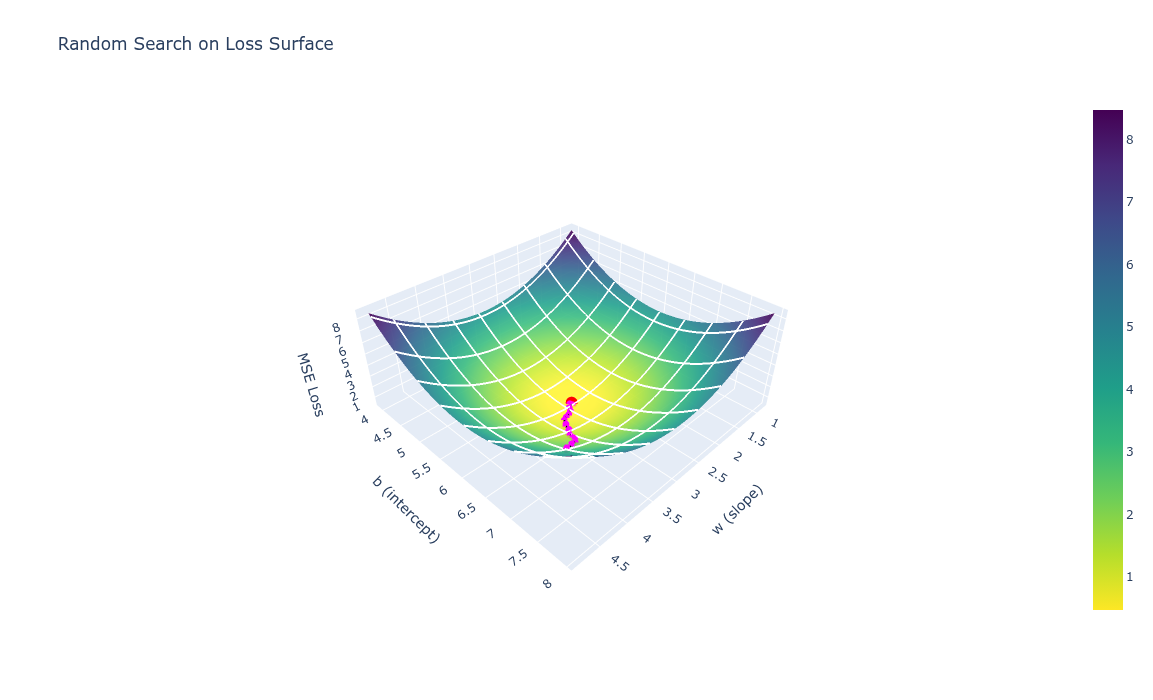

In [15]:
search_path_plot(random_search_path, title='Random Search on Loss Surface')

# 0-th order local optimization: coordinate search

In [31]:
# --- Coordinate descent ---
def coordinate_search(current_w=4, current_b=7, num_iterations=20, directions=10, step_size=0.1):
    global x,y
    # current_w, current_b = 4, 7
    # num_iterations = 20
    # step_size = 0.1
    
    path = [(current_w, current_b, mse_loss(current_w, current_b, x, y))]
    print(f"Step 0: w={current_w:.3f}, b={current_b:.3f}, loss={coordinate_descent_path[-1][2]:.3f}")
    
    for step in range(1, num_iterations+1):
        # evaluate four directions
        candidates = [
            (current_w + step_size, current_b),
            (current_w - step_size, current_b),
            (current_w, current_b + step_size),
            (current_w, current_b - step_size)
        ]
        losses = [mse_loss(wc, bc, x, y) for wc, bc in candidates]
        
        # choose candidate with lowest loss
        min_idx = np.argmin(losses)
        current_w, current_b = candidates[min_idx]
        current_loss = losses[min_idx]
        
        path.append((current_w, current_b, current_loss))
        print(f"Step {step}: w={current_w:.3f}, b={current_b:.3f}, loss={current_loss:.3f}")
    return path

In [32]:
coordinate_search_path = coordinate_search(current_w=4, current_b=7, num_iterations=30, directions=10, step_size=0.1)

Step 0: w=4.000, b=7.000, loss=0.475
Step 1: w=3.900, b=7.000, loss=2.674
Step 2: w=3.900, b=6.900, loss=2.474
Step 3: w=3.800, b=6.900, loss=2.274
Step 4: w=3.800, b=6.800, loss=2.094
Step 5: w=3.700, b=6.800, loss=1.914
Step 6: w=3.700, b=6.700, loss=1.754
Step 7: w=3.600, b=6.700, loss=1.594
Step 8: w=3.600, b=6.600, loss=1.454
Step 9: w=3.500, b=6.600, loss=1.314
Step 10: w=3.500, b=6.500, loss=1.194
Step 11: w=3.400, b=6.500, loss=1.075
Step 12: w=3.400, b=6.400, loss=0.974
Step 13: w=3.300, b=6.400, loss=0.875
Step 14: w=3.300, b=6.300, loss=0.794
Step 15: w=3.200, b=6.300, loss=0.715
Step 16: w=3.200, b=6.200, loss=0.654
Step 17: w=3.100, b=6.200, loss=0.595
Step 18: w=3.100, b=6.100, loss=0.554
Step 19: w=3.000, b=6.100, loss=0.515
Step 20: w=3.000, b=6.000, loss=0.495
Step 21: w=2.900, b=6.000, loss=0.475
Step 22: w=2.900, b=5.900, loss=0.475
Step 23: w=2.900, b=6.000, loss=0.475
Step 24: w=2.900, b=5.900, loss=0.475
Step 25: w=2.900, b=6.000, loss=0.475
Step 26: w=2.900, b=5.

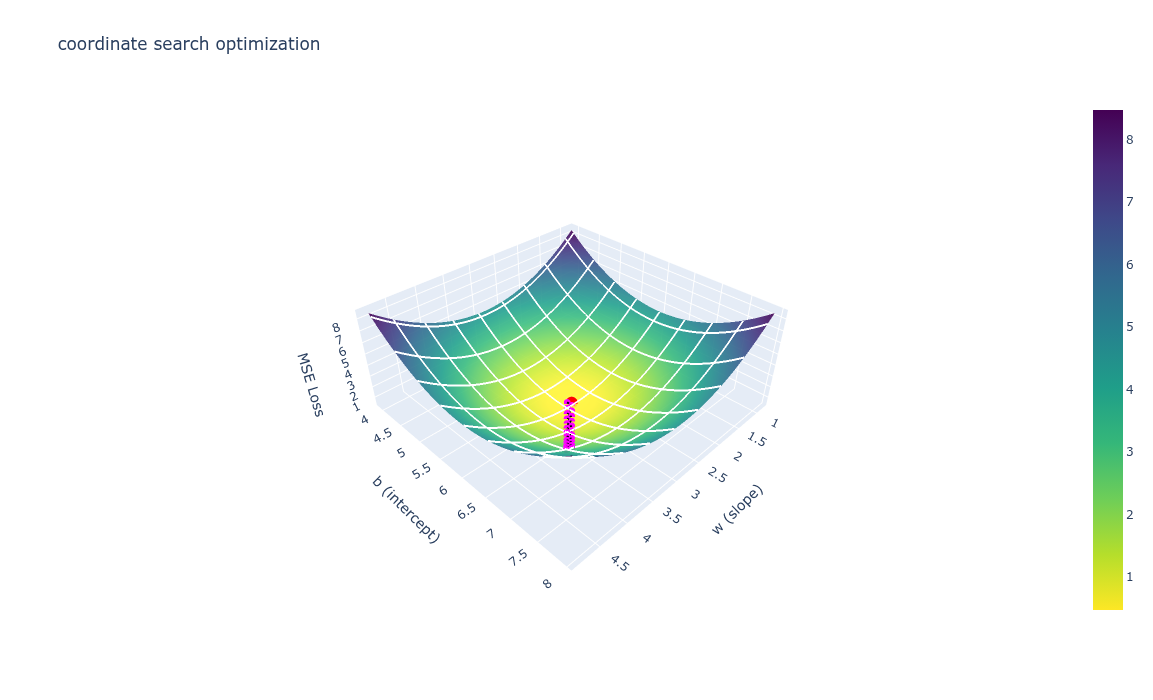

In [33]:
search_path_plot(coordinate_search_path, title='coordinate search optimization')

# 0-th order local optimization: coordinate descent

the **stochastic** version of coordinate search

In [23]:
# --- Coordinate descent ---
def coordinate_descent(current_w=4, current_b=7, num_iterations=20, directions=10, step_size=0.1):
    global x, y
    
    path = [(current_w, current_b, mse_loss(current_w, current_b, x, y))]
    print(f"Step 0: w={current_w:.3f}, b={current_b:.3f}, loss={path[-1][2]:.3f}")
    
    for step in range(1, num_iterations+1):
        # randomly pick coordinate to update
        coord = np.random.choice(['w', 'b'])
        
        if coord == 'w':
            candidates = [
                (current_w + step_size, current_b),
                (current_w - step_size, current_b)
            ]
        else:  # coord == 'b'
            candidates = [
                (current_w, current_b + step_size),
                (current_w, current_b - step_size)
            ]
        
        losses = [mse_loss(wc, bc, x, y) for wc, bc in candidates]
        
        # pick the best candidate if it improves
        min_idx = np.argmin(losses)
        if losses[min_idx] < path[-1][2]:  # only update if loss decreases
            current_w, current_b = candidates[min_idx]
            current_loss = losses[min_idx]
        else:
            current_loss = path[-1][2]  # no update, same loss
        
        path.append((current_w, current_b, current_loss))
        print(f"Step {step}: coord={coord}, w={current_w:.3f}, b={current_b:.3f}, loss={current_loss:.3f}")
    
    return path

In [34]:
coordinate_descent_path = coordinate_descent(current_w=4, current_b=7, num_iterations=30, directions=10, step_size=0.1)

Step 0: w=4.000, b=7.000, loss=2.893
Step 1: coord=b, w=4.000, b=6.900, loss=2.693
Step 2: coord=b, w=4.000, b=6.800, loss=2.513
Step 3: coord=w, w=3.900, b=6.800, loss=2.293
Step 4: coord=w, w=3.800, b=6.800, loss=2.094
Step 5: coord=b, w=3.800, b=6.700, loss=1.933
Step 6: coord=b, w=3.800, b=6.600, loss=1.793
Step 7: coord=w, w=3.700, b=6.600, loss=1.613
Step 8: coord=w, w=3.600, b=6.600, loss=1.454
Step 9: coord=w, w=3.500, b=6.600, loss=1.314
Step 10: coord=w, w=3.400, b=6.600, loss=1.195
Step 11: coord=w, w=3.300, b=6.600, loss=1.095
Step 12: coord=b, w=3.300, b=6.500, loss=0.975
Step 13: coord=b, w=3.300, b=6.400, loss=0.875
Step 14: coord=b, w=3.300, b=6.300, loss=0.794
Step 15: coord=b, w=3.300, b=6.200, loss=0.734
Step 16: coord=w, w=3.200, b=6.200, loss=0.654
Step 17: coord=w, w=3.100, b=6.200, loss=0.595
Step 18: coord=w, w=3.000, b=6.200, loss=0.555
Step 19: coord=b, w=3.000, b=6.100, loss=0.515
Step 20: coord=b, w=3.000, b=6.000, loss=0.495
Step 21: coord=w, w=2.900, b=6.0

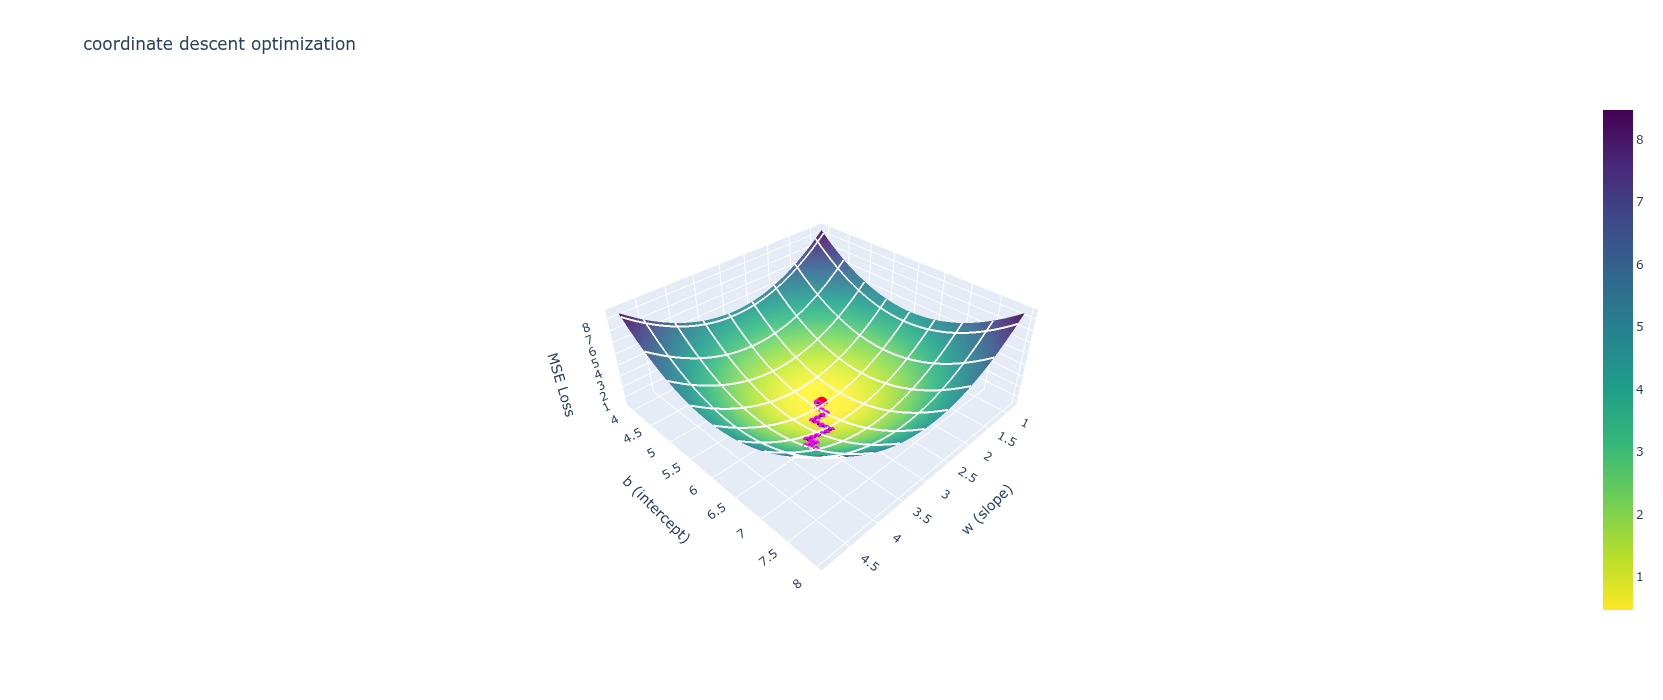

In [35]:
search_path_plot(coordinate_descent_path, title='coordinate descent optimization')

# 1st-order optimization: Gradient descent

Gradient with respect to w
$$
\frac{\partial \mathcal{L}}{\partial w}
= -\frac{2}{n} \sum_{i=1}^n x_i \big( y_i - (w x_i + b) \big)
$$

Gradient with respect to b
$$
\frac{\partial \mathcal{L}}{\partial b}
= -\frac{2}{n} \sum_{i=1}^n \big( y_i - (w x_i + b) \big)
$$

In [40]:
# Use analytical form for gradient calculation
def mse_gradients(w, b, x, y):
    """
    Returns gradients (dw, db) of the MSE loss (with optional L2 on w).
    """
    n = x.shape[0]
    preds = w * x + b
    residuals = y - preds  # shape (n,)
    dw = (-2.0 / n) * np.sum(x * residuals) 
    db = (-2.0 / n) * np.sum(residuals)
    return dw, db


def gradient_descent(current_w=4, current_b=7, num_iterations=20, directions=10, step_size=0.1):

    global x, y
    w, b = current_w, current_b
    path = [(w, b, mse_loss(w, b, x, y))]

    for _ in range(num_iterations):
        # compute gradients
        dw, db = mse_gradients(w, b, x, y)

        # update w and b at the same time !!!
        w = w - step_size * dw
        b = b - step_size * db
        current_loss = mse_loss(w, b, x, y)

        path.append((w, b, current_loss))
        print(f"w={w:.3f}, b={b:.3f}, loss={current_loss:.3f}")

    return path


In [41]:
gradient_descent_path = gradient_descent(current_w=4, current_b=7, num_iterations=20, directions=10, step_size=0.1)

w=3.770, b=6.790, loss=2.021
w=3.587, b=6.621, loss=1.463
w=3.440, b=6.487, loss=1.105
w=3.322, b=6.379, loss=0.877
w=3.228, b=6.293, loss=0.730
w=3.153, b=6.224, loss=0.637
w=3.093, b=6.169, loss=0.577
w=3.045, b=6.125, loss=0.538
w=3.006, b=6.089, loss=0.514
w=2.976, b=6.061, loss=0.498
w=2.951, b=6.038, loss=0.488
w=2.931, b=6.020, loss=0.482
w=2.916, b=6.006, loss=0.477
w=2.903, b=5.994, loss=0.475
w=2.893, b=5.985, loss=0.473
w=2.885, b=5.978, loss=0.472
w=2.878, b=5.972, loss=0.471
w=2.873, b=5.967, loss=0.471
w=2.869, b=5.963, loss=0.471
w=2.866, b=5.960, loss=0.470


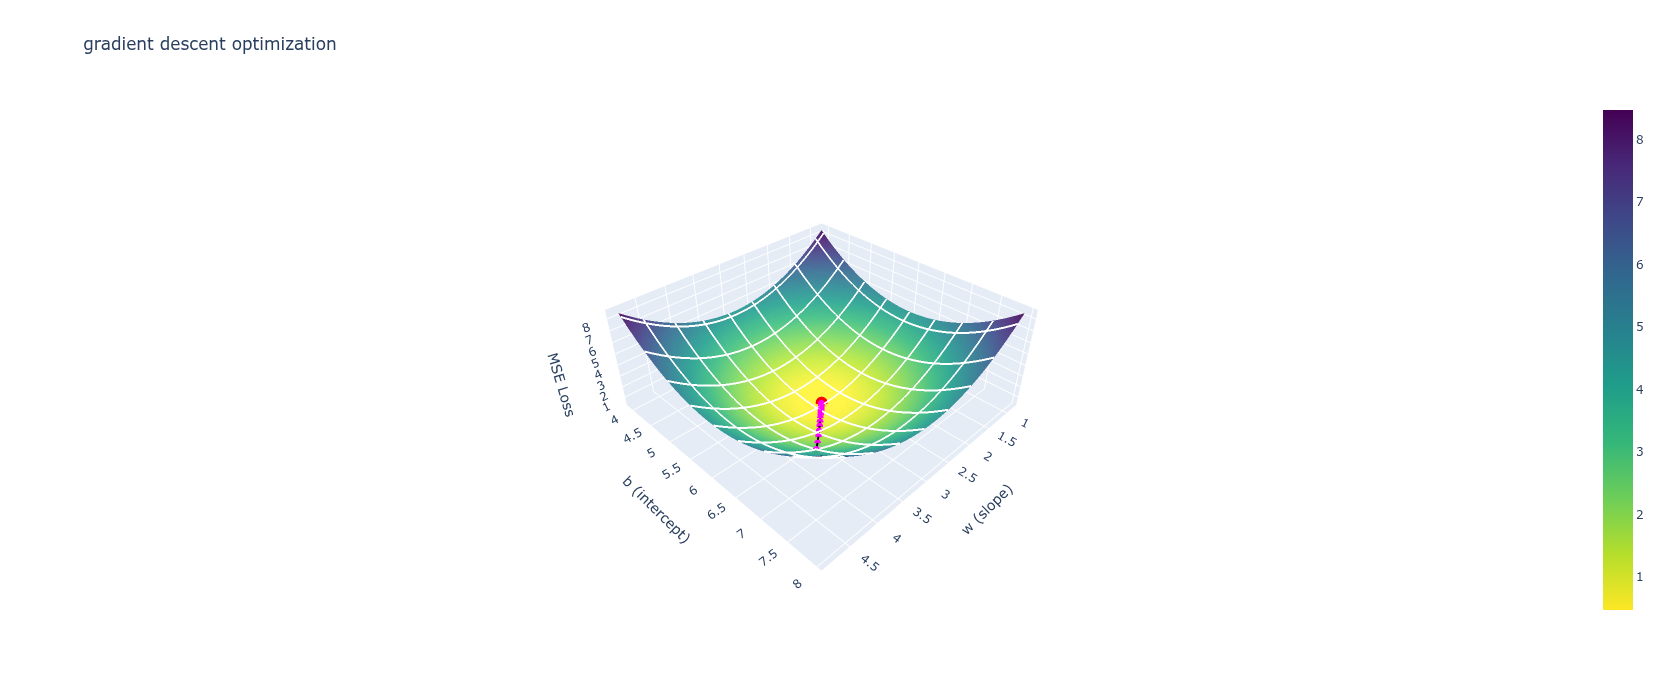

In [42]:
search_path_plot(gradient_descent_path, title='gradient descent optimization')

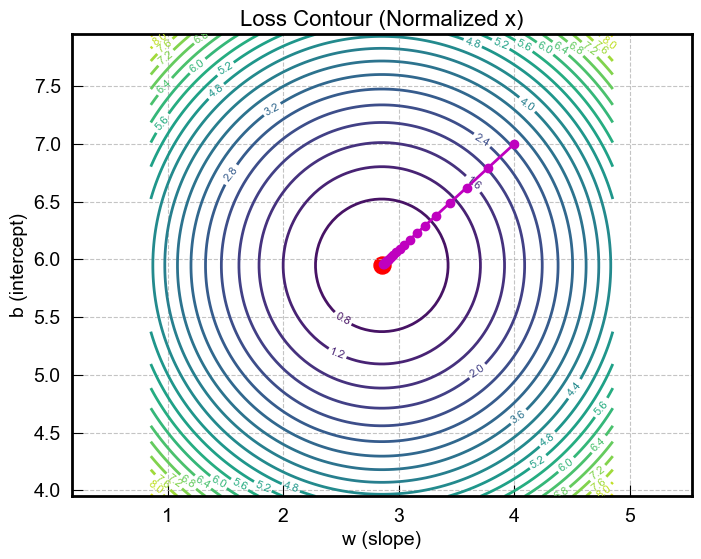

In [54]:
# --- Contour plot ---
plt.figure(figsize=(8,6))
cp = plt.contour(W, B, Loss, levels=20, cmap='viridis')
plt.clabel(cp, inline=True, fontsize=8)
plt.xlabel('w (slope)')
plt.ylabel('b (intercept)')
plt.title('Loss Contour (Normalized x)')

# Highlight the closed-form minimum
plt.scatter(w_min, b_min, color='red', s=150, label='Minimum')

# search path
plt.plot([float(i[0]) for i in gradient_descent_path],
         [float(i[1]) for i in gradient_descent_path], "mo-")

# plt.legend()
plt.xlim([1, 4.5])
plt.ylim([4, 7.5])
plt.axis('equal')
plt.show()

# Stochastic gradient descent

In [55]:
def stochastic_gradient_descent(current_w=4, current_b=7, num_iterations=20, step_size=0.1, batch_size=1):
    global x, y
    w, b = current_w, current_b
    path = [(w, b, mse_loss(w, b, x, y))]

    n = len(x)
    for _ in range(num_iterations):
        # sample random mini-batch
        idx = np.random.choice(n, batch_size, replace=False)
        x_batch, y_batch = x[idx], y[idx]

        # compute gradients on mini-batch
        dw, db = mse_gradients(w, b, x_batch, y_batch)

        # update parameters
        w = w - step_size * dw
        b = b - step_size * db
        current_loss = mse_loss(w, b, x, y)  # full loss (not mini-batch)

        path.append((w, b, current_loss))
        print(f"w={w:.3f}, b={b:.3f}, loss={current_loss:.3f}")

    return path

In [56]:
stochastic_gradient_path1= stochastic_gradient_descent(current_w=4, current_b=7, num_iterations=20, step_size=0.1, batch_size=1)

w=3.702, b=6.657, loss=1.694
w=3.700, b=6.655, loss=1.689
w=3.770, b=6.598, loss=1.734
w=3.155, b=6.206, loss=0.628
w=2.785, b=5.902, loss=0.477
w=2.798, b=5.893, loss=0.476
w=2.777, b=5.770, loss=0.507
w=2.905, b=5.665, loss=0.553
w=2.740, b=5.531, loss=0.657
w=2.592, b=5.815, loss=0.556
w=2.713, b=5.955, loss=0.490
w=2.905, b=5.797, loss=0.496
w=2.775, b=6.046, loss=0.486
w=2.970, b=5.885, loss=0.488
w=3.022, b=5.945, loss=0.499
w=3.056, b=5.983, loss=0.513
w=2.999, b=6.048, loss=0.502
w=2.953, b=6.077, loss=0.497
w=2.981, b=5.918, loss=0.487
w=2.732, b=5.714, loss=0.539


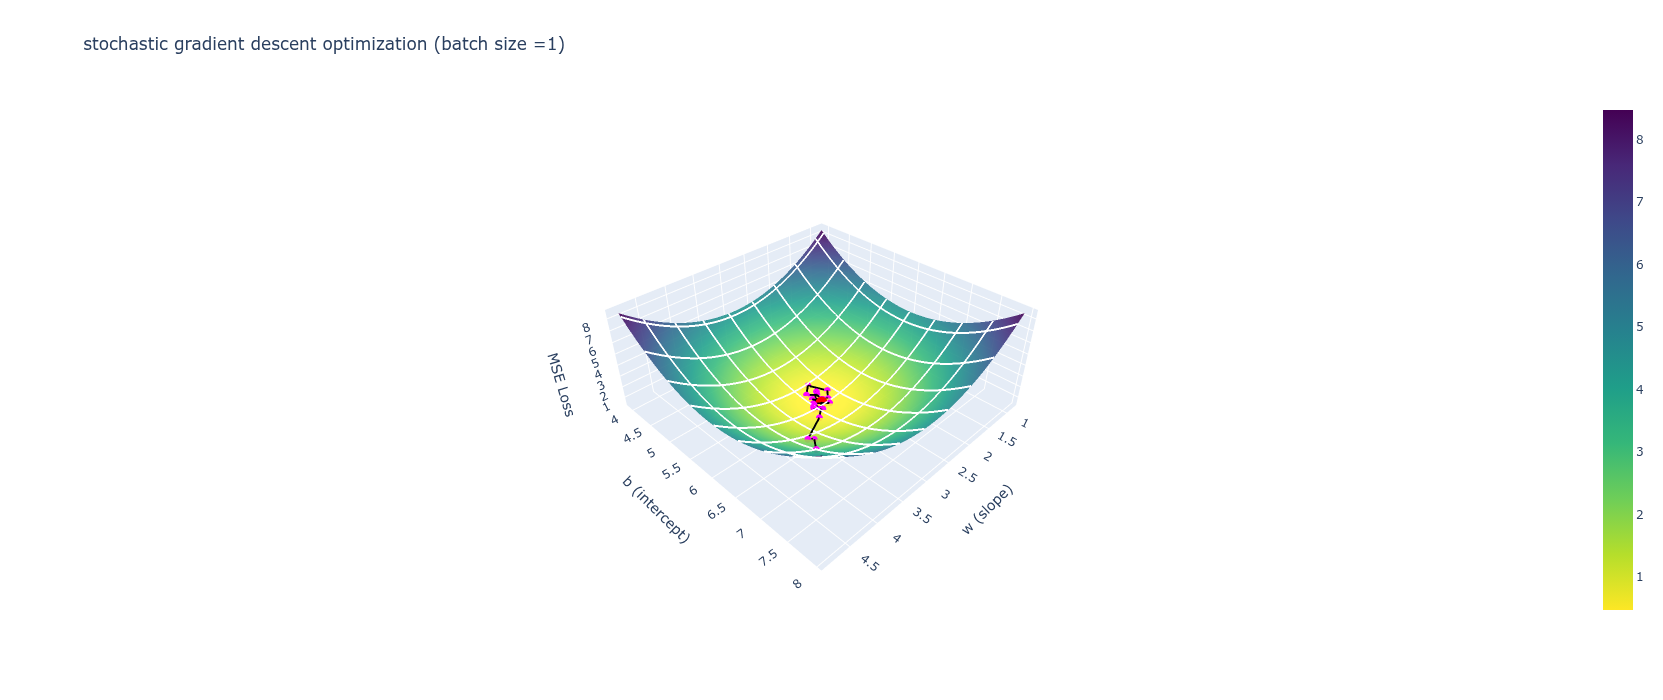

In [57]:
search_path_plot(stochastic_gradient_path1, title='stochastic gradient descent optimization (batch size =1)')

In [59]:
stochastic_gradient_path2 = stochastic_gradient_descent(current_w=4, current_b=7, num_iterations=20, step_size=0.1, batch_size=4)

w=3.522, b=6.534, loss=1.261
w=3.367, b=6.369, loss=0.913
w=3.291, b=6.289, loss=0.778
w=3.164, b=6.222, loss=0.642
w=3.155, b=6.209, loss=0.630
w=3.134, b=6.194, loss=0.610
w=3.067, b=6.119, loss=0.545
w=3.050, b=6.083, loss=0.527
w=2.905, b=6.065, loss=0.486
w=2.828, b=5.966, loss=0.471
w=2.903, b=6.005, loss=0.476
w=2.865, b=6.008, loss=0.474
w=2.929, b=6.035, loss=0.484
w=2.933, b=5.970, loss=0.477
w=2.956, b=5.994, loss=0.483
w=2.918, b=5.920, loss=0.475
w=2.847, b=5.856, loss=0.479
w=2.900, b=5.971, loss=0.473
w=2.872, b=6.000, loss=0.473
w=2.819, b=5.934, loss=0.471


In [60]:
search_path_plot(stochastic_gradient_path2, title='stochastic gradient descent optimization (batch size =4)')

# 2nd order local optimization

In [61]:
def newton_method(current_w=4, current_b=7, num_iterations=10):
    global x, y
    w, b = current_w, current_b
    path = [(w, b, mse_loss(w, b, x, y))]

    n = len(x)

    # Precompute Hessian (constant for quadratic MSE loss)
    H = np.array([
        [2*np.mean(x**2), 2*np.mean(x)],
        [2*np.mean(x), 2]
    ])
    # calculation of inversion of matrices is usually computationally costly
    H_inv = np.linalg.inv(H)

    for _ in range(num_iterations):
        # Gradient
        dw = -2*np.mean(x * (y - (w*x + b)))
        db = -2*np.mean(y - (w*x + b))
        grad = np.array([dw, db])

        # Newton update
        update = H_inv @ grad
        w, b = np.array([w, b]) - update

        current_loss = mse_loss(w, b, x, y)
        path.append((w, b, current_loss))
        print(f"w={w:.3f}, b={b:.3f}, loss={current_loss:.3f}")

    return path

In [62]:
newton_path = newton_method(current_w=4, current_b=7, num_iterations=10)

w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470
w=2.852, b=5.948, loss=0.470


In [63]:
search_path_plot(newton_path, title='2nd-order optimization')